# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment, UnityEnvironmentException
import numpy as np
from tqdm import tqdm

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
# env = UnityEnvironment(file_name="Banana.app")
try:
    env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64") # Linux
    print("we are on Linux")
except UnityEnvironmentException:
    # try Mac
    env = UnityEnvironment(file_name="Banana.app")
    print("we are on Mac")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


we are on Mac


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [5]:
import torch
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device(type='cpu')

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

In [6]:
from model import QNetwork
import random
import torch
import numpy as np
from torch import nn
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2



In [7]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [8]:
def dqn(
    agent,
    n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
    feedback_every_secs=30, keep_last_scores=100,
    file_name_where_to_save='checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): the agent that takes decisions
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        feedback_every_secs (int): how often (in secs.) do you want to have feedback about the scores.
        keep_last_scores (int): I will keep this many scores and then report on their statistics.
    """
    all_scores = []  # ALL scores
    scores_window = deque(maxlen=keep_last_scores)  # last <keep_last_scores> scores
    eps = eps_start                    # initialize epsilon
    last_time = time.time()
    for i_episode in tqdm(range(1, n_episodes+1)):
        # print("Resetting the episode...\n")
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        # print("... environment reset!\n")
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state=state, eps=eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            agent.step(state=state, action=action, reward=reward, next_state=next_state, done=done)
            state = next_state                             # roll over the state to next time step
            if done:
                # print("===> Environment finished this episode after %d steps (max = %d) (ie, 'done' == True)" % (t, max_t))
                break 
        scores_window.append(score)       # save most recent score
        all_scores.append(score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if time.time() - last_time >= feedback_every_secs:
            print('\rEpisode {}, eps: {:.3f}\tAverage Score (last {} episodes): {:.2f}'.format(i_episode, eps, keep_last_scores, np.mean(scores_window)))
            last_time = time.time()
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    print('\rEpisode {}, eps: {:.3f}\tAverage Score (last {} episodes): {:.2f}'.format(i_episode, eps, keep_last_scores, np.mean(scores_window)))
    print("\n Saving best network on '%s'" % (file_name_where_to_save))
    torch.save(agent.qnetwork_local.state_dict(), file_name_where_to_save)
    return all_scores

In [9]:
# create an agent
from dqn_agent import Agent

hidden_sizes = [int(round(state_size * .8)), int(round(state_size * .6)), int(round(action_size * 2))]
# self.hidden_sizes = [int(round(state_size * 10)), int(round(state_size * 5)), int(round(action_size * 10))]
fc = nn.Sequential(
    nn.Linear(state_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], action_size)
)
main_model = QNetwork(name="main", fc=fc)
target_model = QNetwork(name="target", fc=fc)


In [ ]:
# #################################
# this agent solves the problem!
solving_agent = Agent(
    main_model=main_model,
    target_network=target_model,
    is_double=False,
    update_every_steps=10, 
    lr=1e-3, 
    batch_size=64, 
    memory_size=int(1e5))
# #################################

agent_dqn = Agent(
    main_model=main_model,
    target_network=target_model,
    is_double=False,
    update_every_steps=10, 
    lr=1e-3, 
    batch_size=64, 
    memory_size=int(1e5))


In [22]:
agent_double_dqn = Agent(
    main_model=main_model,
    target_network=target_model,
    is_double=True,
    update_every_steps=10, 
    lr=1e-3, 
    batch_size=64, 
    memory_size=int(1e5))

TypeError: can't pickle torch._C.Generator objects

In [10]:
# agent.set_models_from(torch_file_name='checkpoint.pth')
prob_not_random_at_start_default=(1-0.995) # /15
scores_dqn = dqn(
    solving_agent, 
    n_episodes=1000, 
    feedback_every_secs=45, 
    keep_last_scores=100, 
    eps_decay=1 - prob_not_random_at_start_default)

  6%|▌         | 55/1000 [00:45<16:13,  1.03s/it]

Episode 55, eps: 0.759	Average Score (last 100 episodes): 0.33


 12%|█▏        | 118/1000 [01:31<10:15,  1.43it/s]

Episode 118, eps: 0.554	Average Score (last 100 episodes): 0.85


 17%|█▋        | 173/1000 [02:16<12:08,  1.13it/s]

Episode 173, eps: 0.420	Average Score (last 100 episodes): 2.00


 23%|██▎       | 228/1000 [03:01<09:43,  1.32it/s]

Episode 228, eps: 0.319	Average Score (last 100 episodes): 4.20


 28%|██▊       | 285/1000 [03:47<08:57,  1.33it/s]

Episode 285, eps: 0.240	Average Score (last 100 episodes): 6.76


 34%|███▍      | 341/1000 [04:32<08:52,  1.24it/s]

Episode 341, eps: 0.181	Average Score (last 100 episodes): 8.36


 40%|███▉      | 397/1000 [05:18<08:03,  1.25it/s]

Episode 397, eps: 0.137	Average Score (last 100 episodes): 8.67


 45%|████▌     | 451/1000 [06:03<07:31,  1.22it/s]

Episode 451, eps: 0.104	Average Score (last 100 episodes): 9.00


 50%|█████     | 503/1000 [06:49<07:41,  1.08it/s]

Episode 503, eps: 0.080	Average Score (last 100 episodes): 9.99


 56%|█████▌    | 558/1000 [07:35<06:04,  1.21it/s]

Episode 558, eps: 0.061	Average Score (last 100 episodes): 11.05


 62%|██████▏   | 616/1000 [08:20<04:56,  1.29it/s]

Episode 616, eps: 0.046	Average Score (last 100 episodes): 11.44


 67%|██████▋   | 674/1000 [09:05<04:12,  1.29it/s]

Episode 674, eps: 0.034	Average Score (last 100 episodes): 12.12


 73%|███████▎  | 730/1000 [09:51<03:32,  1.27it/s]

Episode 730, eps: 0.026	Average Score (last 100 episodes): 12.83


 73%|███████▎  | 732/1000 [09:53<03:29,  1.28it/s]


Environment solved in 633 episodes!	Average Score: 13.12
Episode 733, eps: 0.025	Average Score (last 100 episodes): 13.12

 Saving best network on 'checkpoint.pth'


In [ ]:
prob_not_random_at_start_default=(1-0.995) # /15
scores_double_dqn = dqn(
    agent_double_dqn, 
    n_episodes=1000, 
    feedback_every_secs=45, 
    keep_last_scores=100, 
    eps_decay=1 - prob_not_random_at_start_default)

  4%|▍         | 38/1000 [00:45<10:29,  1.53it/s]  

Episode 38, eps: 0.827	Average Score (last 100 episodes): 0.16


 10%|█         | 104/1000 [01:30<10:25,  1.43it/s]

Episode 104, eps: 0.594	Average Score (last 100 episodes): 0.62


 13%|█▎        | 131/1000 [02:32<3:19:21, 13.76s/it]

Episode 131, eps: 0.519	Average Score (last 100 episodes): 0.96


 13%|█▎        | 132/1000 [03:47<7:44:32, 32.11s/it]

Episode 132, eps: 0.516	Average Score (last 100 episodes): 0.94


 13%|█▎        | 133/1000 [04:48<9:51:34, 40.94s/it]

Episode 133, eps: 0.513	Average Score (last 100 episodes): 0.98


 13%|█▎        | 134/1000 [05:45<10:58:27, 45.62s/it]

Episode 134, eps: 0.511	Average Score (last 100 episodes): 0.95


 17%|█▋        | 171/1000 [06:30<11:29,  1.20it/s]   

Episode 171, eps: 0.424	Average Score (last 100 episodes): 1.60


 21%|██        | 208/1000 [06:59<10:32,  1.25it/s]

In [ ]:
1 - (1-0.995)/25

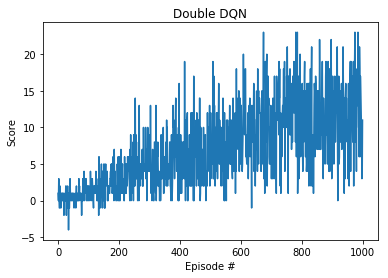

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_double_dqn)), scores_double_dqn)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Double DQN')
plt.show()

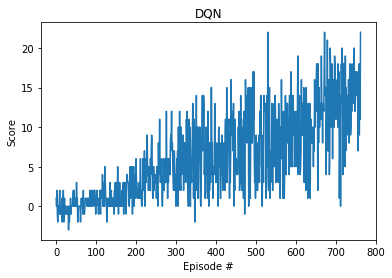

In [11]:
# scores = dqn(agent, n_episodes=50, feedback_every_secs=15, keep_last_scores=10)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_dqn)), scores_dqn)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('DQN')
plt.show()

When finished, you can close the environment.

In [14]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```